# Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew 

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler,MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression

# Read Data

In [2]:

spark = SparkSession.builder.appName("Invistico_Airline").getOrCreate()
df = spark.read.csv('data/Invistico_Airline.csv',inferSchema=True,header=True)
# Selection of columns (to have a more clear view of data frame)
df.select('satisfaction',
 'Gender',
 'Customer Type',
 'Age',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes').show(5)

+------------+------+--------------+---+--------------------------+------------------------+
|satisfaction|Gender| Customer Type|Age|Departure Delay in Minutes|Arrival Delay in Minutes|
+------------+------+--------------+---+--------------------------+------------------------+
|   satisfied|Female|Loyal Customer| 65|                         0|                       0|
|   satisfied|  Male|Loyal Customer| 47|                       310|                     305|
|   satisfied|Female|Loyal Customer| 15|                         0|                       0|
|   satisfied|Female|Loyal Customer| 60|                         0|                       0|
|   satisfied|Female|Loyal Customer| 70|                         0|                       0|
+------------+------+--------------+---+--------------------------+------------------------+
only showing top 5 rows



In [3]:
# List of all our columns
df.printSchema()

root
 |-- satisfaction: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)

In [4]:
df.select('satisfaction',
 'Gender',
 'Customer Type',
 'Age',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes').describe().show()

+-------+------------+------+-----------------+------------------+--------------------------+------------------------+
|summary|satisfaction|Gender|    Customer Type|               Age|Departure Delay in Minutes|Arrival Delay in Minutes|
+-------+------------+------+-----------------+------------------+--------------------------+------------------------+
|  count|      129880|129880|           129880|            129880|                    129880|                  129487|
|   mean|        null|  null|             null| 39.42795657530028|        14.713712657838004|       15.09112883918849|
| stddev|        null|  null|             null|15.119359950371694|         38.07112621503648|       38.46565024011906|
|    min|dissatisfied|Female|   Loyal Customer|                 7|                         0|                       0|
|    max|   satisfied|  Male|disloyal Customer|                85|                      1592|                    1584|
+-------+------------+------+-----------------+-

# Splitting in columns in different types

In [5]:
df.dtypes

[('satisfaction', 'string'),
 ('Gender', 'string'),
 ('Customer Type', 'string'),
 ('Age', 'int'),
 ('Type of Travel', 'string'),
 ('Class', 'string'),
 ('Flight Distance', 'int'),
 ('Seat comfort', 'int'),
 ('Departure/Arrival time convenient', 'int'),
 ('Food and drink', 'int'),
 ('Gate location', 'int'),
 ('Inflight wifi service', 'int'),
 ('Inflight entertainment', 'int'),
 ('Online support', 'int'),
 ('Ease of Online booking', 'int'),
 ('On-board service', 'int'),
 ('Leg room service', 'int'),
 ('Baggage handling', 'int'),
 ('Checkin service', 'int'),
 ('Cleanliness', 'int'),
 ('Online boarding', 'int'),
 ('Departure Delay in Minutes', 'int'),
 ('Arrival Delay in Minutes', 'int')]

In [6]:
categorical_features = []
numerical_features = []

for x in df.dtypes:
    if x[1] == "string":
        categorical_features.append(x)
    if x[1] == "int":
        
        if df.agg({x[0]:"max"}).collect()[0][0] <= 5:
            categorical_features.append(x)
        else:
            numerical_features.append(x)
            
        

# checking for null values

In [7]:
from pyspark.sql.functions import col,isnan, when, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()



+------------+------+-------------+---+--------------+-----+---------------+------------+---------------------------------+--------------+-------------+---------------------+----------------------+--------------+----------------------+----------------+----------------+----------------+---------------+-----------+---------------+--------------------------+------------------------+
|satisfaction|Gender|Customer Type|Age|Type of Travel|Class|Flight Distance|Seat comfort|Departure/Arrival time convenient|Food and drink|Gate location|Inflight wifi service|Inflight entertainment|Online support|Ease of Online booking|On-board service|Leg room service|Baggage handling|Checkin service|Cleanliness|Online boarding|Departure Delay in Minutes|Arrival Delay in Minutes|
+------------+------+-------------+---+--------------+-----+---------------+------------+---------------------------------+--------------+-------------+---------------------+----------------------+--------------+----------------------

## Only column "Arrival Delay in Minutes" has null values

In [8]:
df.printSchema()
# satisfaction,Gender,Customer Type

root
 |-- satisfaction: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)

## Imputing null values

In [9]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCol='Arrival Delay in Minutes',
                 outputCol='ADMI',
                ).setStrategy("median")

df = imputer.fit(df).transform(df)

# Plots

## Gender

In [10]:
df_men = df[df["Gender"]=="Male"]
df_women = df[df["Gender"]=="Female"]

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Satisfaction of men')

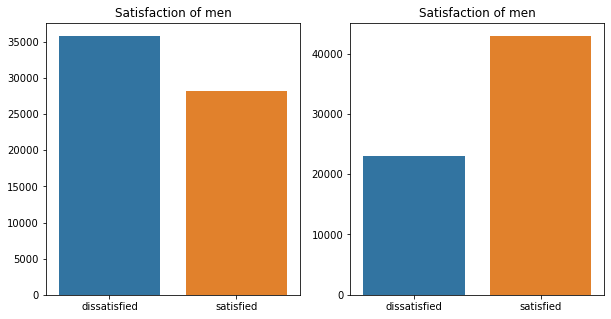

In [11]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

df_men_satisfaction = df_men.groupby("satisfaction").count()
count_v = [ x[0] for x in df_men_satisfaction.select("count").collect()]
satisfaction_v = [ x[0] for x in df_men_satisfaction.select("satisfaction").collect()]

ax[0] = sns.barplot(satisfaction_v,count_v,ax=ax[0])
ax[0].set_title("Satisfaction of men")


df_women_satisfaction = df_women.groupby("satisfaction").count()
count_v = [ x[0] for x in df_women_satisfaction.select("count").collect()]
satisfaction_v = [ x[0] for x in df_women_satisfaction.select("satisfaction").collect()]

ax[1] = sns.barplot(satisfaction_v,count_v,ax=ax[1])
ax[1].set_title("Satisfaction of men")

From these bar plots we can conclude that in general men tend to complain more about (not satisfied) the flight,
this can be a feature to use in our model as it show that there is a relation between satisfaction and gender but it need further esploration

## Age

In [12]:
df_age = df.select("satisfaction","Age")

df_age_satisfaction=df_age.filter(df_age["satisfaction"] == "satisfied")
df_age_dissatisfaction=df_age.filter(df_age["satisfaction"] == "dissatisfied")



/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


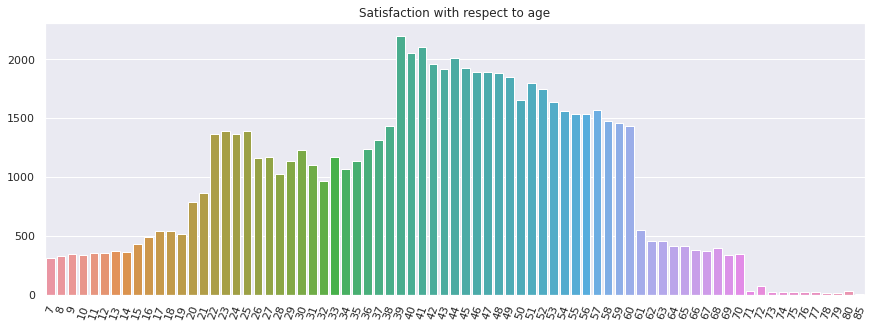

In [13]:
sns.set(rc={'figure.figsize':(14.7,5)})

df_age_satisfaction = df_age_satisfaction.groupby("Age").count()
age_v = [ x[0] for x in df_age_satisfaction.select("Age").collect()]
satisfaction_v = [ x[0] for x in df_age_satisfaction.select("count").collect()]
ax = sns.barplot(age_v,satisfaction_v)
ax.set_title("Satisfaction with respect to age")
x=ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


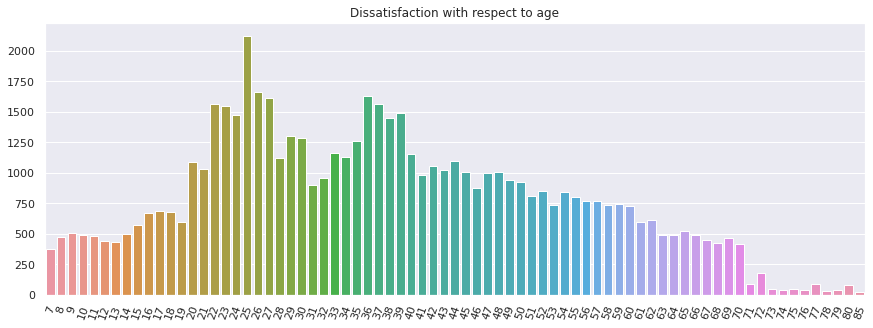

In [14]:
sns.set(rc={'figure.figsize':(14.7,5)})

df_age_dissatisfaction = df_age_dissatisfaction.groupby("Age").count()
age_v = [ x[0] for x in df_age_dissatisfaction.select("Age").collect()]
satisfaction_v = [ x[0] for x in df_age_dissatisfaction.select("count").collect()]
ax = sns.barplot(age_v,satisfaction_v)
ax.set_title("Dissatisfaction with respect to age")
x=ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)

## Class

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


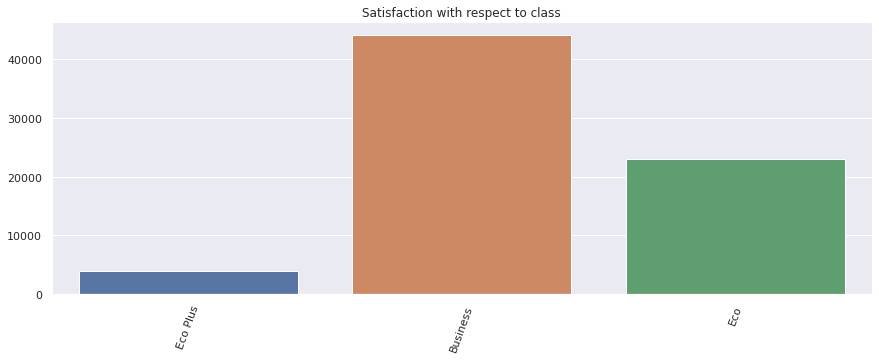

In [15]:
df_class = df.select("satisfaction","Class")
df_class_satisfied=df_class.filter(df_class["satisfaction"] == "satisfied")
df_class_dissatisfied=df_class.filter(df_class["satisfaction"] == "dissatisfied")

df_class_satisfied = df_class_satisfied.groupby("Class").count()
class_v = [ x[0] for x in df_class_satisfied.select("Class").collect()]
satisfaction_v = [ x[0] for x in df_class_satisfied.select("count").collect()]
ax = sns.barplot(class_v,satisfaction_v)
ax.set_title("Satisfaction with respect to class")
x=ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


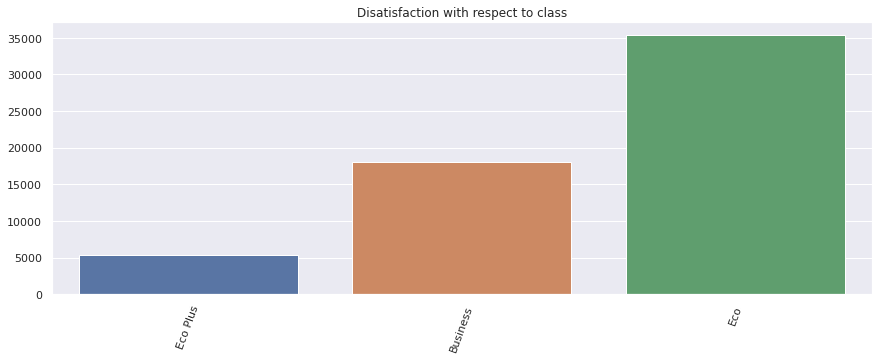

In [16]:
df_class_dissatisfied = df_class_dissatisfied.groupby("Class").count()
class_v = [ x[0] for x in df_class_dissatisfied.select("Class").collect()]
satisfaction_v = [ x[0] for x in df_class_dissatisfied.select("count").collect()]
ax = sns.barplot(class_v,satisfaction_v)
ax.set_title("Disatisfaction with respect to class")
x=ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)

The people most satisfied are obviously the people in business class and dissatisfied, are the people in economy

## Flight Distance and Departure delay

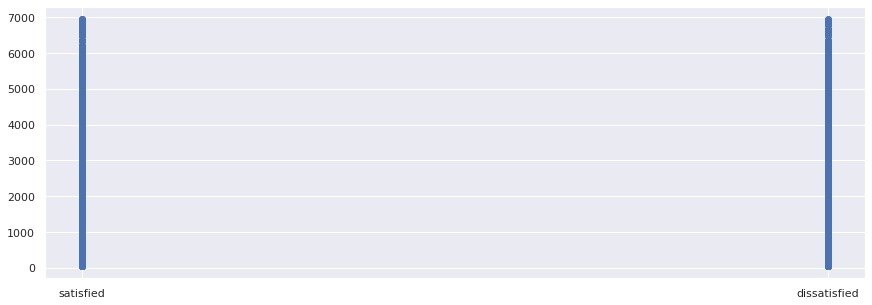

In [17]:

df_dst=df.select("satisfaction","Flight Distance")
dst_v = [ x[0] for x in df_dst.select("Flight Distance").collect()]
satisfaction_v = [ x[0] for x in df_dst.select("satisfaction").collect()]
plt.scatter(satisfaction_v,dst_v)

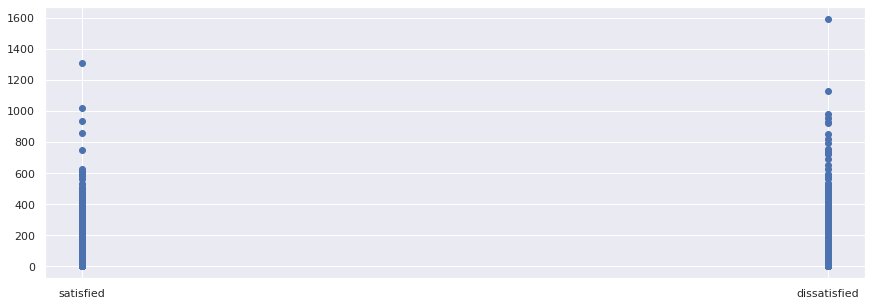

In [18]:
df_dly=df.select("satisfaction","Departure Delay in Minutes")
dly_v = [ x[0] for x in df_dly.select("Departure Delay in Minutes").collect()]
satisfaction_v = [ x[0] for x in df_dly.select("satisfaction").collect()]
plt.scatter(satisfaction_v,dly_v)

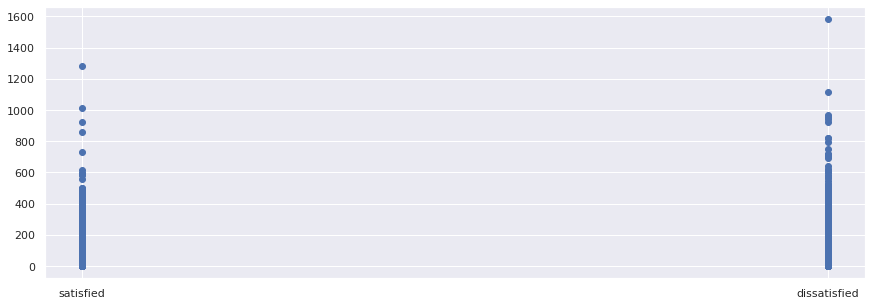

In [19]:
df_dly=df.select("satisfaction","Arrival Delay in Minutes")
dly_v = [ x[0] for x in df_dly.select("Arrival Delay in Minutes").collect()]
satisfaction_v = [ x[0] for x in df_dly.select("satisfaction").collect()]
plt.scatter(satisfaction_v,dly_v)

From these 3 plots, we can deduce that there is a relation between the satisfaction and the delay of a flight

But no relation between the flight distance and the satisfaction, we can safely remove this feature if needed

A relation exists as well between Departure and Arrival delay, but because Arrilval delay had missing the best solution will be to select departure delay

# Preprocessing, Piepline and Modeling

## split test_train

In [20]:
train, test = df.randomSplit([0.77, 0.33])

## Pipeline

In [21]:
categorical_features = ['satisfaction',
 'Gender',
 'Customer Type',
 'Type of Travel',
 'Class',
 'Seat comfort',
 'Departure/Arrival time convenient',
 'Food and drink',
 'Gate location',
 'Inflight wifi service',
 'Inflight entertainment',
 'Online support',
 'Ease of Online booking',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Cleanliness',
 'Online boarding']

continues_features = ['Age',
 'Flight Distance',
 'Departure Delay in Minutes',
 'ADMI']


pipeline_list=[]
featuress = []

# StringIndexer to convert string values into numerical
[pipeline_list.append(StringIndexer(inputCol=c, outputCol= c+'_indexed')) for c in categorical_features]
[featuress.append(c+'_indexed') for c in categorical_features]


# Feature Scaling
assembler = VectorAssembler(inputCols=continues_features, outputCol='continuous_features')
pipeline_list.append(assembler)

minmaxscalar = MinMaxScaler(inputCol='continuous_features', outputCol='continuous_features_scaled')
pipeline_list.append(minmaxscalar)
featuress.append('continuous_features_scaled')

assembler_final = VectorAssembler(inputCols=['satisfaction_indexed', 'Gender_indexed', 'Customer Type_indexed', 'Type of Travel_indexed', 'Class_indexed', 'Seat comfort_indexed', 'Departure/Arrival time convenient_indexed', 'Food and drink_indexed', 'Gate location_indexed', 'Inflight wifi service_indexed', 'Inflight entertainment_indexed', 'Online support_indexed', 'Ease of Online booking_indexed', 'On-board service_indexed', 'Leg room service_indexed', 'Baggage handling_indexed', 'Checkin service_indexed', 'Cleanliness_indexed', 'Online boarding_indexed', 'continuous_features_scaled'],
                                  outputCol='features')
pipeline_list.append(assembler_final)


label_encoder = StringIndexer(inputCol='satisfaction', outputCol= 'satisfaction_encoded')
pipeline_list.append(label_encoder)
featuress.append('satisfaction_encoded')

# ml model
model = LogisticRegression(featuresCol = 'features', labelCol = 'satisfaction_encoded', maxIter=5)
pipeline_list.append(model)

pipeline = Pipeline(stages=pipeline_list)

pipeline_model = pipeline.fit(train)
data_train = pipeline_model.transform(train)


## Prediction

In [22]:
predictions = pipeline_model.transform(test)
predictions.head(1)

[Row(satisfaction='dissatisfied', Gender='Female', Customer Type='Loyal Customer', Age=7, Type of Travel='Personal Travel', Class='Eco', Flight Distance=1338, Seat comfort=4, Departure/Arrival time convenient=4, Food and drink=4, Gate location=4, Inflight wifi service=5, Inflight entertainment=4, Online support=5, Ease of Online booking=5, On-board service=4, Leg room service=2, Baggage handling=4, Checkin service=4, Cleanliness=5, Online boarding=5, Departure Delay in Minutes=0, Arrival Delay in Minutes=0, ADMI=0, satisfaction_indexed=1.0, Gender_indexed=0.0, Customer Type_indexed=0.0, Type of Travel_indexed=1.0, Class_indexed=1.0, Seat comfort_indexed=2.0, Departure/Arrival time convenient_indexed=0.0, Food and drink_indexed=1.0, Gate location_indexed=1.0, Inflight wifi service_indexed=1.0, Inflight entertainment_indexed=0.0, Online support_indexed=1.0, Ease of Online booking_indexed=1.0, On-board service_indexed=0.0, Leg room service_indexed=3.0, Baggage handling_indexed=0.0, Checki

In [23]:
predictions.printSchema()

root
 |-- satisfaction: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)